In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import matplotlib.ticker as mtick
from scipy.spatial import distance_matrix
from fc_nets import *
from utils import *

sns.set(font_scale=1.1)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{dsfont}'



from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import warnings
warnings.filterwarnings('ignore')
# colors = ['blue', 'orange', 'olive', 'brown', 'cornflowerblue', 'red', 'k', 'purple']
colors = ['lightsteelblue', 'cornflowerblue', 'blue', 'midnightblue']
label_size = 16
hps = {
    'lenaic': {'n': 15, 'd': 2, 'm_teacher': 3, 'm_student': 20, 'init_scales_teacher': [1.0, 1.0], 'init_scales_student': [0.5, 0.0], 'seed': 0, 'gamma': 0.455, 'warmup_mult_factor': 1.0},  # good stabilization and decrease in the clustering coefficient
}

y tensor([ 0.9664, -0.5862,  0.4440,  0.9520,  0.8456,  0.6576, -1.0138,  0.7839,
        -0.2553, -0.2928, -1.5520,  0.8203,  0.8531, -0.1936, -1.1354])
batch_size=1, gamma=0.130: train loss 1.353839979856275e-05, test loss 0.000609822163823992, l1 1.2837960720062256, l2_param 3.3091703270576756, relu_dist 0.07333333045244217
batch_size=1, gamma=0.455: train loss 1.0185355677094776e-05, test loss 0.0001622068084543571, l1 1.5292003154754639, l2_param 2.630120505701539, relu_dist 0.3766666650772095
batch_size=1, gamma=0.455: train loss 1.1195015758858062e-05, test loss 0.0001382110349368304, l1 1.531028389930725, l2_param 2.5981035578808527, relu_dist 0.3700000047683716
batch_size=1, gamma=0.455: train loss 1.1127009202027693e-05, test loss 5.4106094466988e-05, l1 1.5084540843963623, l2_param 2.5883562928618633, relu_dist 0.3566666543483734


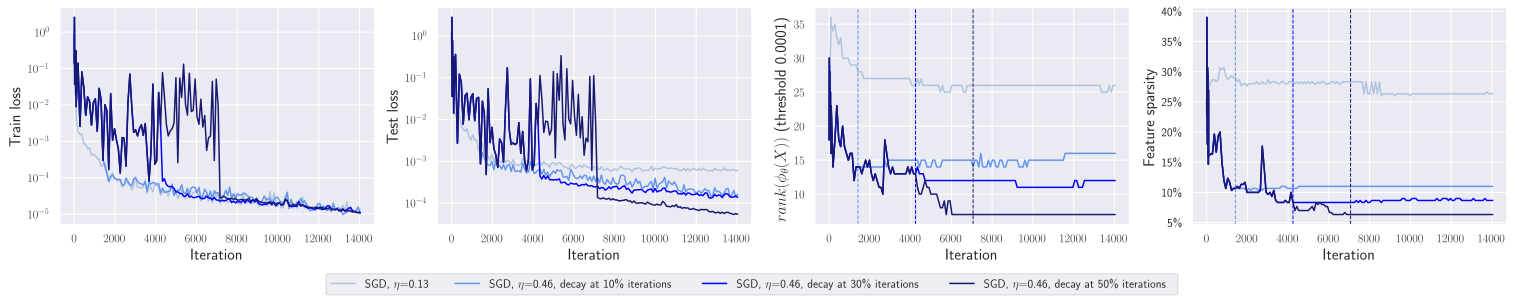

In [2]:
### d=2 case for which we can visualize the neurons if needed
exp = 'lenaic' 
X, y, X_test, y_test, net_teacher = get_data_two_layer_relu_net(hps[exp]['n'], hps[exp]['d'], hps[exp]['m_teacher'], hps[exp]['init_scales_teacher'], hps[exp]['seed'])
x_log_scale = False
num_iter, iters_loss = get_iters_eval(n_iter_power=4.15, x_log_scale=x_log_scale)  # 4.15

n_plots = 4
lp = 0.1
l0_threshold = 0.1
weight_avg = 0.0
l0_threshold_grad_matrix = 0.0001

gammas = [0.13, 0.455, 0.455, 0.455]
schedule_lengths = [0.0, 0.1, 0.3, 0.5]
decay_factors = [1.0, 2.0, 4.0, 5.0]
batch_sizes = [1] * len(schedule_lengths)

nets_all = []
plt.figure(figsize = (26, 4))  # (12, 4) for 2 plots, (22, 4) for 3 plots
for i, (gamma, batch_size, schedule_length, decay_factor) in enumerate(zip(gammas, batch_sizes, schedule_lengths, decay_factors)):
    np.random.seed(hps[exp]['seed'])
    torch.manual_seed(hps[exp]['seed'])

    net_init = FCNet2Layers(n_feature=hps[exp]['d'], n_hidden=hps[exp]['m_student']) 
    net_init.init_gaussian(init_scales=hps[exp]['init_scales_student'])
    train_losses, test_losses, nets = train_fc_net(X, y, X_test, y_test, gamma, batch_size, net_init, iters_loss, num_iter, thresholds=[int(schedule_length*num_iter)], decays=[decay_factor]) 
    nets_all.append(nets)
    lp_norms_sing = [(np.linalg.svd(net.layer1.weight.data.numpy() * np.abs(net.layer2.weight.data.numpy().T))[1]**lp).sum() for net in nets]
    l1_norms_sing = [np.linalg.svd(net.layer1.weight.data.numpy() * np.abs(net.layer2.weight.data.numpy().T))[1].sum() for net in nets]
    lp_norms_features_sing = np.array([(np.linalg.svd(F.relu(net.layer1(X)).detach().numpy())[1]**lp).sum() for net in nets])
    l0_norms_features_sing = np.array([(np.linalg.svd(F.relu(net.layer1(X)).detach().numpy())[1] > l0_threshold).sum() for net in nets])
    l2_norms = [(np.sum(net.layer1.weight.data.numpy()**2) + np.sum(net.layer2.weight.data.numpy()**2))**0.5 for net in nets]
    feature_sparsity = np.array([net.feature_sparsity(X) for net in nets])
    relu_distances = [torch.abs((net_init.layer1.weight @ X.T > 0).float() - (net.layer1.weight @ X.T > 0).float()).mean() for net in nets]
    activation_frac_nonzeros = [((F.relu(net.layer1(X)) * net.layer2.weight).data.numpy() != 0).mean()*100 for net in nets]

    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    grad_matrix_ranks = compute_grad_matrix_ranks(nets, X_test[:n_params], l0_threshold_grad_matrix)
    print('batch_size={}, gamma={:.3f}: train loss {}, test loss {}, l1 {}, l2_param {}, relu_dist {}'.format(batch_size, gamma, train_losses[-1], test_losses[-1], l1_norms_sing[-1], l2_norms[-1], relu_distances[-1]))

    label = '{}, $\eta$={:.2f}'.format('SGD' if batch_size < hps[exp]['n'] else 'GD', gamma if schedule_length > 0 else gamma / decay_factor) + \
            ((', decay at ' + str(int(schedule_length*100)) + r'\% iterations') if schedule_length > 0 else '')

    ax = plt.subplot(1, n_plots, 1)
    plt.plot(iters_loss, train_losses, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Train loss', fontsize=label_size)
    # plt.legend()

    ax = plt.subplot(1, n_plots, 2)
    plt.plot(iters_loss, test_losses, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Test loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 3)
    plt.plot(iters_loss, grad_matrix_ranks, label=label, color=colors[i], linestyle='solid')
    if schedule_lengths[i] > 0:
        plt.axvline(x=schedule_lengths[i]*num_iter, color=colors[i], linestyle='--', linewidth=1)
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('$rank(\phi_\\theta(X))$ (threshold {})'.format(l0_threshold_grad_matrix), fontsize=label_size)
    # plt.legend()

    ax = plt.subplot(1, n_plots, 4)
    plt.plot(iters_loss, 100*feature_sparsity, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    if schedule_lengths[i] > 0:
        plt.axvline(x=schedule_lengths[i]*num_iter, color=colors[i], linestyle='--', linewidth=1)
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Feature sparsity', fontsize=label_size)

plt.legend(loc='upper center', bbox_to_anchor=(-1.4, -0.2), ncol=7)
plt.savefig("plots/fc_net_d=2_exp={}_lp={}.pdf".format(exp, lp), bbox_inches='tight')
plt.show()

Singular values of the features [6.1785402e+00 4.8558793e+00 1.2291864e-07 1.1097640e-07 8.8501992e-08
 6.7928646e-08 5.7454429e-08 5.6060085e-08 4.2899423e-08 3.9469423e-08
 3.3945700e-08 2.5034421e-08 2.1435810e-08 1.3752144e-08 7.9010594e-09]


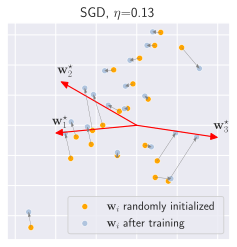

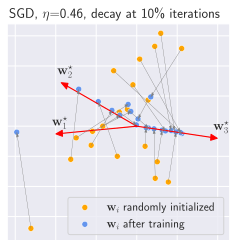

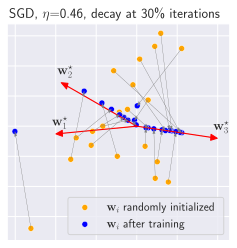

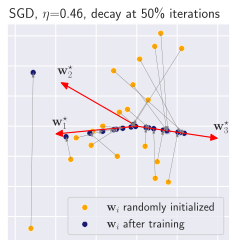

In [3]:
features_sing = np.linalg.svd(nets_all[0][-1].layer1(X).detach().numpy())[1]
print('Singular values of the features', features_sing)

for i_net, (nets, gamma, batch_size, schedule_length, decay_factor) in enumerate(zip(nets_all, gammas, batch_sizes, schedule_lengths, decay_factors)):
    plt.figure(figsize=(4.0, 4.0))
    net = nets[-1]
    train_loss, test_loss = torch.mean((net(X) - y)**2).item(), torch.mean((net(X_test) - y_test)**2).item()
    label = '{}, $\eta$={:.2f}'.format('SGD' if batch_size < hps[exp]['n'] else 'GD', gamma if schedule_length > 0 else gamma / decay_factor) + \
            ((', decay at ' + str(int(schedule_length*100)) + r'\% iterations') if schedule_length > 0 else '')  # + '\n train loss: {:.5f}, test loss: {:.5f}'.format(train_loss, test_loss)

    w1_teacher, w2_teacher = net_teacher.layer1.weight.data.numpy(), net_teacher.layer2.weight.data.numpy()
    w1_init, w2_init = net_init.layer1.weight.data.numpy(), net_init.layer2.weight.data.numpy()
    w1, w2 = net.layer1.weight.data.numpy(), net.layer2.weight.data.numpy()
    w_teacher_merged = w1_teacher# * w2_teacher.T
    w_init_merged = w1_init# * w2_init.T
    w_merged = w1# * w2.T

    for i_teacher in range(hps[exp]['m_teacher']):
        plt.arrow(0, 0, w_teacher_merged[i_teacher, 0], w_teacher_merged[i_teacher, 1], color='red', head_width=0.05, head_length=0.08, length_includes_head=True, linewidth=1.0)  # label='$\mathbf{w}_i^{\star}$ ground truth' if i_teacher == 0 else ''
        plt.text(w_teacher_merged[i_teacher, 0] - 0.05, w_teacher_merged[i_teacher, 1] + 0.07, '$\mathbf{w}_' + str(i_teacher+1) + '^{\star}$')
    
    for i_student in range(hps[exp]['m_student']):
        plt.arrow(w_init_merged[i_student, 0], w_init_merged[i_student, 1], w_merged[i_student, 0] - w_init_merged[i_student, 0], w_merged[i_student, 1] - w_init_merged[i_student, 1], color='gray', head_width=0.03, head_length=0.04, length_includes_head=True, linewidth=0.2)

    ax = sns.scatterplot(w_init_merged[:, 0], w_init_merged[:, 1], color='orange', label='$\mathbf{w}_i$ randomly initialized')
    ax = sns.scatterplot(w_merged[:, 0], w_merged[:, 1], color=colors[i_net], label='$\mathbf{w}_i$ after training')

    ax.set_xlim(-1.6, 1.15)
    ax.set_ylim(-0.95, 0.85)
    
    plt.legend()
    # plt.axis('off')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.title(label, fontsize=14)
    # plt.xticks(fontsize=11)
    # plt.yticks(fontsize=11)
    plt.savefig("plots/fc_net_2d_neuron_movement_exp={}_model{}.pdf".format(exp, i_net + 1), bbox_inches='tight')
    plt.show()